<a href="https://colab.research.google.com/github/MouadEttali/Machine-Learning-Study-/blob/main/Time_Series_Forecasting_LSTM_CNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
#Loading the data jena climate from keras datasets
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


The data represents climate data taken from 2009 to 2017 with 10 minute intervals

# Part 1 : Simple LSTM Time series Forecasting

## Exploratory Data analysis

In [4]:
#Reading data and storing it in a variable df 
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
#Getting the rows starting from 5 , take every 6 rows which is basically getting the data of every hour.
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
# putting the date column as index for the dataframe and converting it to datetime type
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
#Getting data of first 24 hours
df[:24]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


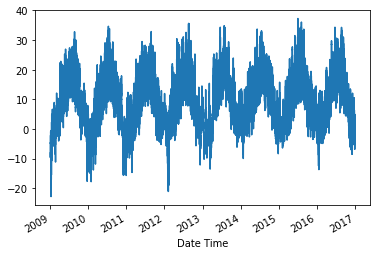

In [9]:
#Plotting Temperature data
temp = df['T (degC)']
temp.plot()

In [7]:
# we're trying to make a function that converts our series into something like the below matrix where each number represents an hour
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy() # this will just convert my series to a numpy array and using that array we will populate X and y 
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]] # this make the list 
    X.append(row) # this populates X with the list of the 5 elements 
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

## Splitting the data for training and testing

In [11]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1))) #5x1 vector for each of our inputs
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

## Training the model

In [15]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 44.5865 - root_mean_squared_error: 6.6773

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 17s 8ms/step - loss: 44.5678 - root_mean_squared_error: 6.6759 - val_loss: 1.9037 - val_root_mean_squared_error: 1.3797
Epoch 2/10
1870/1875 [============================>.] - ETA: 0s - loss: 3.9240 - root_mean_squared_error: 1.9809

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 14s 8ms/step - loss: 3.9168 - root_mean_squared_error: 1.9791 - val_loss: 0.6605 - val_root_mean_squared_error: 0.8127
Epoch 3/10
1869/1875 [============================>.] - ETA: 0s - loss: 1.2421 - root_mean_squared_error: 1.1145

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 14s 8ms/step - loss: 1.2401 - root_mean_squared_error: 1.1136 - val_loss: 0.5463 - val_root_mean_squared_error: 0.7391
Epoch 4/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.8068 - root_mean_squared_error: 0.8982

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.8067 - root_mean_squared_error: 0.8982 - val_loss: 0.5149 - val_root_mean_squared_error: 0.7176
Epoch 5/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.7069 - root_mean_squared_error: 0.8408

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 15s 8ms/step - loss: 0.7075 - root_mean_squared_error: 0.8411 - val_loss: 0.4973 - val_root_mean_squared_error: 0.7052
Epoch 6/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.6761 - root_mean_squared_error: 0.8223

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 15s 8ms/step - loss: 0.6759 - root_mean_squared_error: 0.8221 - val_loss: 0.4949 - val_root_mean_squared_error: 0.7035
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6626 - root_mean_squared_error: 0.8140 - val_loss: 0.5026 - val_root_mean_squared_error: 0.7090
Epoch 8/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.6563 - root_mean_squared_error: 0.8101

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.6551 - root_mean_squared_error: 0.8094 - val_loss: 0.4914 - val_root_mean_squared_error: 0.7010
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6505 - root_mean_squared_error: 0.8065 - val_loss: 0.4953 - val_root_mean_squared_error: 0.7038
Epoch 10/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6479 - root_mean_squared_error: 0.8049

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 14s 8ms/step - loss: 0.6480 - root_mean_squared_error: 0.8050 - val_loss: 0.4830 - val_root_mean_squared_error: 0.6950


In [16]:
# Load the best model we found
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [17]:
# Visualizing predictions and actuals in a datframe
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

,Train Predictions,Actuals
0,-9.799084,-9.67
1,-9.648168,-9.17
2,-8.815159,-8.10
3,-7.353129,-7.66
4,-7.130466,-7.04
...,...,...
59995,6.120047,6.07
59996,7.084981,9.88
59997,12.462453,13.53
59998,15.824400,15.43


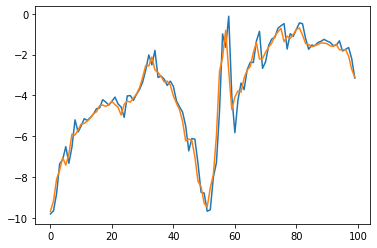

In [19]:
import matplotlib.pyplot as plt
# Visualiazing only the first 100 to get an interpretable graph
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])

In [20]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,15.543586,14.02
1,13.308601,13.67
2,13.023848,12.27
3,11.438688,11.19
4,10.395884,10.85
...,...,...
4995,17.374725,18.27
4996,17.362268,17.85
4997,17.154104,16.65
4998,15.905619,15.85


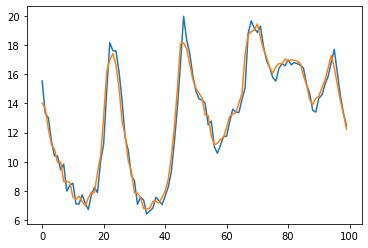

In [21]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [22]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

,Test Predictions,Actuals
0,14.367210,13.99
1,13.225853,13.46
2,12.858597,12.93
3,12.451147,12.43
4,12.018167,12.17
...,...,...
5081,-1.155915,-0.98
5082,-1.467411,-1.40
5083,-1.600204,-2.75
5084,-3.388644,-2.89


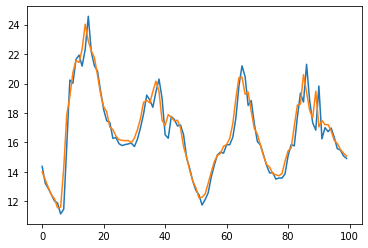

In [23]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

# Part 2 : Multivariate Time series Forecasting using LSTM , GRU & 1D CNN

Seeing as how we'll use multiple models, we'll make a function to automate the  ( predicted / actuals dataframe ) + graph all at once.

In [26]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

(      Predictions  Actuals
 0       14.367210    13.99
 1       13.225853    13.46
 2       12.858597    12.93
 3       12.451147    12.43
 4       12.018167    12.17
 ...           ...      ...
 5081    -1.155915    -0.98
 5082    -1.467411    -1.40
 5083    -1.600204    -2.75
 5084    -3.388644    -2.89
 5085    -3.209008    -3.93
 
 [5086 rows x 2 columns], 0.6252178006264509)

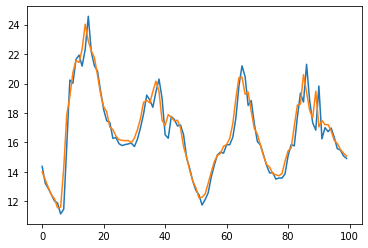

In [27]:
plot_predictions(model1, X_test1, y_test1)

## Model 2 : Convolutional 1D neural network

In [28]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 2056      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


The advantage of the CNN d1 is the small number of parameters which means less training time and run faster

In [29]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [30]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
1851/1875 [============================>.] - ETA: 0s - loss: 1.7185 - root_mean_squared_error: 1.3109INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 1.7087 - root_mean_squared_error: 1.3072 - val_loss: 0.7425 - val_root_mean_squared_error: 0.8617
Epoch 2/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.7863 - root_mean_squared_error: 0.8867INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.7860 - root_mean_squared_error: 0.8866 - val_loss: 0.5347 - val_root_mean_squared_error: 0.7312
Epoch 3/10
1852/1875 [============================>.] - ETA: 0s - loss: 0.6942 - root_mean_squared_error: 0.8332INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 5s 2ms/step - loss: 0.6936 - root_mean_squared_error: 0.8328 - val_loss: 0.5079 - val_root_mean_squared_error: 0.7127
Epoch 4/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6716 - root_mean_squared_error: 0.8195INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.6712 - root_mean_squared_error: 0.8193 - val_loss: 0.4978 - val_root_mean_squared_error: 0.7056
Epoch 5/10
1857/1875 [============================>.] - ETA: 0s - loss: 0.6645 - root_mean_squared_error: 0.8152INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.6645 - root_mean_squared_error: 0.8152 - val_loss: 0.4963 - val_root_mean_squared_error: 0.7045
Epoch 6/10
1855/1875 [============================>.] - ETA: 0s - loss: 0.6655 - root_mean_squared_error: 0.8158INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.6648 - root_mean_squared_error: 0.8154 - val_loss: 0.4942 - val_root_mean_squared_error: 0.7030
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6635 - root_mean_squared_error: 0.8145 - val_loss: 0.4984 - val_root_mean_squared_error: 0.7060
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6613 - root_mean_squared_error: 0.8132 - val_loss: 0.5179 - val_root_mean_squared_error: 0.7197
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6631 - root_mean_squared_error: 0.8143 - val_loss: 0.5104 - val_root_mean_squared_error: 0.7145
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6598 - root_mean_squared_error: 0.8123 - val_loss: 0.5049 - val_root_mean_squared_error: 0.7105


## Model 3 : Gated recurrent unit GRU

GRU is less complex than LSTM and that helps a lot with overfitting problems and speed of training

In [31]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [32]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
1869/1875 [============================>.] - ETA: 0s - loss: 29.8395 - root_mean_squared_error: 5.4626

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 16s 7ms/step - loss: 29.7535 - root_mean_squared_error: 5.4547 - val_loss: 0.9607 - val_root_mean_squared_error: 0.9801
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.5464 - root_mean_squared_error: 1.2435

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 14s 7ms/step - loss: 1.5459 - root_mean_squared_error: 1.2433 - val_loss: 0.5857 - val_root_mean_squared_error: 0.7653
Epoch 3/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.8183 - root_mean_squared_error: 0.9046

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 13s 7ms/step - loss: 0.8183 - root_mean_squared_error: 0.9046 - val_loss: 0.5243 - val_root_mean_squared_error: 0.7241
Epoch 4/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.6938 - root_mean_squared_error: 0.8330

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 14s 8ms/step - loss: 0.6934 - root_mean_squared_error: 0.8327 - val_loss: 0.5122 - val_root_mean_squared_error: 0.7157
Epoch 5/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6620 - root_mean_squared_error: 0.8136

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.6618 - root_mean_squared_error: 0.8135 - val_loss: 0.5042 - val_root_mean_squared_error: 0.7100
Epoch 6/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6507 - root_mean_squared_error: 0.8067

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.6507 - root_mean_squared_error: 0.8066 - val_loss: 0.4993 - val_root_mean_squared_error: 0.7066
Epoch 7/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.6466 - root_mean_squared_error: 0.8041

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 13s 7ms/step - loss: 0.6473 - root_mean_squared_error: 0.8045 - val_loss: 0.4939 - val_root_mean_squared_error: 0.7028
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6447 - root_mean_squared_error: 0.8029 - val_loss: 0.4979 - val_root_mean_squared_error: 0.7056
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6420 - root_mean_squared_error: 0.8013 - val_loss: 0.5021 - val_root_mean_squared_error: 0.7086
Epoch 10/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6401 - root_mean_squared_error: 0.8000

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 15s 8ms/step - loss: 0.6406 - root_mean_squared_error: 0.8004 - val_loss: 0.4881 - val_root_mean_squared_error: 0.6987


# Using more variables for forecasting

## Model 4 : LSTM Multivariate adding time column 


In [34]:
temp_df = pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [35]:
day = 60*60*24
year = 365.2425*day
# turning the seconds column to a sin / cos day and year variables to give it a periodique behavior
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


**The  reason we do this and drop the seconds column is that this last is an ever increasing value that doesn't translate the periodicity of the time value. By translating seconds into cos and sin columns we preserve the time behavior vis a vis the other climate columns**

In [38]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


In [41]:
# Now we're trying to make a function that converts our series into something like the below matrix where each number represents an hour
# [[[t1,ds1...], [t2,ds2...], [t3,ds3...], [t4,ds4...], [t5,ds5...]]] [t6]
# [[[t2,ds2...], [t3,ds3...], [t4,ds4...], [t5,ds5...], [t6,ds6...]]] [t7]
# [[[t3,ds3...], [t4,ds4...], [t5,ds5...], [t6,ds6...], [t7,ds7...]]] [t8]

def df_to_X_y2(df, window_size=6): # we'll use a window of 6 now
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0] # to get the temperature value as our target
    y.append(label)
  return np.array(X), np.array(y)

In [42]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((70085, 6, 5), (70085,))

In [43]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

In [45]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])
                          
def preprocess(X):
  '''
   standard Scaling the temperature column to the other sin and cos column 
  by standizing the temperature values 
  ( i.e substracting the mean and dividing by the standard deviation)
  ''' 
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

In [47]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17920     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [48]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [49]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
1870/1875 [============================>.] - ETA: 0s - loss: 29.7501 - root_mean_squared_error: 5.4544

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 17s 8ms/step - loss: 29.6847 - root_mean_squared_error: 5.4484 - val_loss: 4.1795 - val_root_mean_squared_error: 2.0444
Epoch 2/10
1867/1875 [============================>.] - ETA: 0s - loss: 5.3508 - root_mean_squared_error: 2.3132

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 16s 8ms/step - loss: 5.3418 - root_mean_squared_error: 2.3112 - val_loss: 2.1499 - val_root_mean_squared_error: 1.4663
Epoch 3/10
1870/1875 [============================>.] - ETA: 0s - loss: 2.1021 - root_mean_squared_error: 1.4499

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 15s 8ms/step - loss: 2.1004 - root_mean_squared_error: 1.4493 - val_loss: 1.0170 - val_root_mean_squared_error: 1.0085
Epoch 4/10
1870/1875 [============================>.] - ETA: 0s - loss: 1.0472 - root_mean_squared_error: 1.0234

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 16s 9ms/step - loss: 1.0468 - root_mean_squared_error: 1.0232 - val_loss: 0.6959 - val_root_mean_squared_error: 0.8342
Epoch 5/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.7573 - root_mean_squared_error: 0.8703

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 15s 8ms/step - loss: 0.7581 - root_mean_squared_error: 0.8707 - val_loss: 0.5354 - val_root_mean_squared_error: 0.7317
Epoch 6/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.6180 - root_mean_squared_error: 0.7861

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.6185 - root_mean_squared_error: 0.7865 - val_loss: 0.4691 - val_root_mean_squared_error: 0.6849
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.5630 - root_mean_squared_error: 0.7503

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 15s 8ms/step - loss: 0.5632 - root_mean_squared_error: 0.7504 - val_loss: 0.4393 - val_root_mean_squared_error: 0.6628
Epoch 8/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.5430 - root_mean_squared_error: 0.7369

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 16s 8ms/step - loss: 0.5429 - root_mean_squared_error: 0.7368 - val_loss: 0.4188 - val_root_mean_squared_error: 0.6471
Epoch 9/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.5326 - root_mean_squared_error: 0.7298

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 15s 8ms/step - loss: 0.5332 - root_mean_squared_error: 0.7302 - val_loss: 0.4170 - val_root_mean_squared_error: 0.6457
Epoch 10/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.5280 - root_mean_squared_error: 0.7266

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 16s 8ms/step - loss: 0.5281 - root_mean_squared_error: 0.7267 - val_loss: 0.4121 - val_root_mean_squared_error: 0.6419


(      Predictions  Actuals
 0       13.352336    13.46
 1       12.927578    12.93
 2       12.519649    12.43
 3       12.209185    12.17
 4       12.295289    11.55
 ...           ...      ...
 5080    -1.099369    -0.98
 5081    -1.464748    -1.40
 5082    -1.721806    -2.75
 5083    -3.156246    -2.89
 5084    -3.199720    -3.93
 
 [5085 rows x 2 columns], 0.47415076517010984)

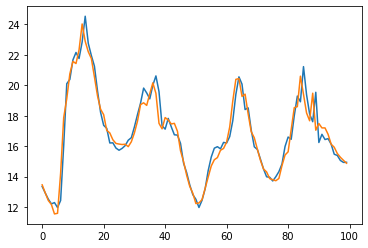

In [50]:
plot_predictions1(model4, X2_test, y2_test)

## Model 5 : LSTM Multivariate adding pressure column





In [51]:
p_temp_df = pd.concat([df['p (mbar)'], temp_df], axis=1)
p_temp_df.head()

,p (mbar),Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


In [52]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [53]:
X3, y3 = df_to_X_y3(p_temp_df)
X3.shape, y3.shape

((70084, 7, 6), (70084, 2))

In [54]:
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

In [56]:
p_training_mean3 = np.mean(X3_train[:, :, 0])
p_training_std3 = np.std(X3_train[:, :, 0])

temp_training_mean3 = np.mean(X3_train[:, :, 1])
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X):  # same purpose as the preprocess function
  X[:, :, 0] = (X[:, :, 0] - p_training_mean3) / p_training_std3
  X[:, :, 1] = (X[:, :, 1] - temp_training_mean3) / temp_training_std3

def preprocess_output3(y): 
  y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
  y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
  return y

In [57]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

In [ ]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

In [59]:
model5 = Sequential()
model5.add(InputLayer((7, 6)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear'))

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18176     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 2)                 18        
                                                                 
Total params: 18,714
Trainable params: 18,714
Non-trainable params: 0
_________________________________________________________________


In [60]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [61]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5])

Epoch 1/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.1690 - root_mean_squared_error: 0.4111

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 20s 10ms/step - loss: 0.1685 - root_mean_squared_error: 0.4104 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818
Epoch 2/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0243 - root_mean_squared_error: 0.1559

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 16s 9ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1294
Epoch 3/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1102

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0883

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 5/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0801

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 6/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0756

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 16s 9ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0650
Epoch 7/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0730

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 8/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0717

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 16s 9ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 10/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0702

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602


In [64]:
# New function for plotting both temp and pressure data predictions and actual
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.402456,0.412451,-0.780618,-0.793439
1,0.356521,0.353683,-0.764496,-0.763123
2,0.316337,0.323123,-0.727993,-0.721893
3,0.320815,0.250251,-0.676448,-0.652773
4,0.278340,0.254952,-0.589575,-0.652773
...,...,...,...,...
95,0.690943,0.716869,-0.406724,-0.416310
96,0.652673,0.687485,-0.406214,-0.399333
97,0.636206,0.663978,-0.389604,-0.399333
98,0.639712,0.641646,-0.379506,-0.400546


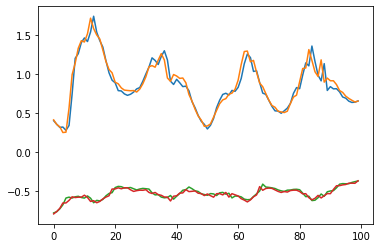

In [63]:
plot_predictions2(model5, X3_test, y3_test)

In [65]:
def postprocess_temp(arr): # to retrieve the correct temperature values from the output ( since the output will be standerdized )
  arr = (arr*temp_training_std3) + temp_training_mean3
  return arr

def postprocess_p(arr): # to retrieve the correct pressure values from the output
  arr = (arr*p_training_std3) + p_training_mean3
  return arr

In [66]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = postprocess_p(predictions[:, 0]), postprocess_temp(predictions[:, 1]) # plotting real values after postprocessing
  p_actuals, temp_actuals = postprocess_p(y[:, 0]), postprocess_temp(y[:, 1])
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.844965,12.93,982.535767,982.43
1,12.454153,12.43,982.668701,982.68
2,12.112259,12.17,982.969727,983.02
3,12.150360,11.55,983.394775,983.59
4,11.788982,11.59,984.111206,983.59
...,...,...,...,...
95,15.299415,15.52,985.619080,985.54
96,14.973815,15.27,985.623291,985.68
97,14.833712,15.07,985.760254,985.68
98,14.863541,14.88,985.843567,985.67


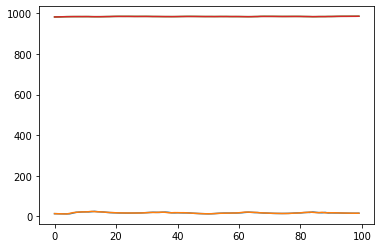

In [67]:
post_processed_df = plot_predictions2(model5, X3_test, y3_test)
post_processed_df

The reason this plot looks unreadable is because the scales of temperature and pressure are so mismatched ( -30 to +42 C for temp against 900s for pressure )  and in the same graph those two value basically cancel each other out visually due to the y axis being compressed for each of them

One solution is to single them out and plot each in a different graph

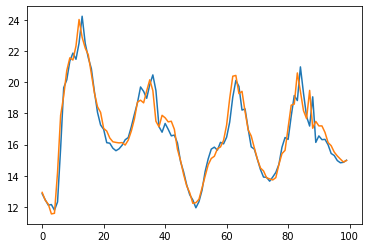

In [69]:
start, end = 0, 100
plt.plot(post_processed_df['Temperature Predictions'][start:end])
plt.plot(post_processed_df['Temperature Actuals'][start:end])

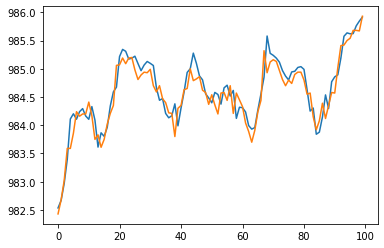

In [70]:
plt.plot(post_processed_df['Pressure Predictions'][start:end])
plt.plot(post_processed_df['Pressure Actuals'][start:end])

## Model 6 : 2 LSTM layers for higher accuracy 

In [71]:
# Increasing the complexity of the model by adding a new LSTM layer 
model6 = Sequential()
model6.add(InputLayer((7, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 32)             4992      
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
Total params: 30,362
Trainable params: 30,362
Non-trainable params: 0
_________________________________________________________________


In [72]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [73]:
model6.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp6])

Epoch 1/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.1493 - root_mean_squared_error: 0.3864

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 31s 15ms/step - loss: 0.1490 - root_mean_squared_error: 0.3861 - val_loss: 0.0438 - val_root_mean_squared_error: 0.2093
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0357 - root_mean_squared_error: 0.1889

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.0357 - root_mean_squared_error: 0.1888 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1586
Epoch 3/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.1395

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 27s 15ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.1072

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 5/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0937

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 6/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0844

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 7/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0779

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0750

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 27s 14ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 9/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 10/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0725

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640


## Model 7 : GRU Multivariate with pressure and time data 

In [74]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

cp7 = ModelCheckpoint('model6/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 64)             832       
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_14 (Dense)            (None, 8)                 3080      
                                                                 
 dense_15 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
_________________________________________________________________


In [75]:
model7.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp7])

Epoch 1/10
1853/1875 [============================>.] - ETA: 0s - loss: 0.0922 - root_mean_squared_error: 0.3036INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0913 - root_mean_squared_error: 0.3022 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1407
Epoch 2/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1201INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 3/10
1855/1875 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0972INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 4/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0885INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 5/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0834INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0738
Epoch 6/10
1861/1875 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0802INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0780INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 8/10
1859/1875 [============================>.] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0765INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0765 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 9/10
1855/1875 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0752INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 10/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0744INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
